# Exercise 3 - Putting it all together - Model Training

In this notebook we will tie everything together to and use what we have learnt to try our hand in the competition.

The steps are similar to Exercise 2:
1. Explore the competition dataset
2. Build a convnet from scratch that performs reasonably well
3. Evaluate training and validation accuracy
4. Score the model against test set and submit result

Let's get started!

## Download and Explore the Dataset

Let's start by downloading our dataset, a .zip of 1,226 PNG pictures of different poses, and extracting it locally.

The contents of the `.zip` are extracted to the base directory, which contains `train` and `val` subdirectories for you to do training and validation. The folders have the following structure:

```
---------------
train
|- ChairPose
|- ChildPose
|- Dabbing
|- HandGun
|- HandShake
|- HulkSmash
|- KoreanHeart
|- KungfuCrane
|- KungfuSalute
|- Salute
|- WarriorPose

val
|- ChairPose
|- ChildPose
|- Dabbing
|- HandGun
|- HandShake
|- HulkSmash
|- KoreanHeart
|- KungfuCrane
|- KungfuSalute
|- Salute
|- WarriorPose
```

In [1]:
# Creating two directories - "data" and "data/trainset_11classes_0_00000" 
!mkdir data && mkdir data/trainset_11classes_0_00000
# Downloading the ai-camp competition dataset
!wget -N https://ai-camp.s3-us-west-2.amazonaws.com/trainset_11classes_0_00000.zip
# Unzip the data into the folder "data/trainset_11classes_0_00000"
!unzip -qq -n trainset_11classes_0_00000.zip -d data/trainset_11classes_0_00000
# Switch directory to "data/trainset_11classes_0_00000" and show its content
!cd data/trainset_11classes_0_00000 && ls

mkdir: cannot create directory ‘data’: File exists
--2019-06-12 18:11:04--  https://ai-camp.s3-us-west-2.amazonaws.com/trainset_11classes_0_00000.zip
Resolving ai-camp.s3-us-west-2.amazonaws.com (ai-camp.s3-us-west-2.amazonaws.com)... 52.218.209.201
Connecting to ai-camp.s3-us-west-2.amazonaws.com (ai-camp.s3-us-west-2.amazonaws.com)|52.218.209.201|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘trainset_11classes_0_00000.zip’ not modified on server. Omitting download.

train  val


In [0]:
import os

base_dir = 'data/trainset_11classes_0_00000'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')

Now, let's find out the total number of images we have in each `train`, `val` and `test`.

In [3]:
# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(base_dir):
    print(root, len(files))

Directory, Number of files
data/trainset_11classes_0_00000 0
data/trainset_11classes_0_00000/train 0
data/trainset_11classes_0_00000/train/WarriorPose 93
data/trainset_11classes_0_00000/train/HulkSmash 88
data/trainset_11classes_0_00000/train/KungfuSalute 92
data/trainset_11classes_0_00000/train/KungfuCrane 88
data/trainset_11classes_0_00000/train/ChildPose 81
data/trainset_11classes_0_00000/train/ChairPose 89
data/trainset_11classes_0_00000/train/Dabbing 89
data/trainset_11classes_0_00000/train/HandGun 93
data/trainset_11classes_0_00000/train/HandShake 83
data/trainset_11classes_0_00000/train/Salute 90
data/trainset_11classes_0_00000/train/KoreanHeart 87
data/trainset_11classes_0_00000/val 0
data/trainset_11classes_0_00000/val/WarriorPose 22
data/trainset_11classes_0_00000/val/HulkSmash 24
data/trainset_11classes_0_00000/val/KungfuSalute 25
data/trainset_11classes_0_00000/val/KungfuCrane 21
data/trainset_11classes_0_00000/val/ChildPose 22
data/trainset_11classes_0_00000/val/ChairPose 

We can see that there are 11 categories/folders in each `train` and `val` folder.

Now let's take a look at a few images to get a better sense of what the `KoreanHeart` and `KungfuCrane` categories look like. First, configure the matplotlib parameters:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 KoreanHeart and 8 KungfuCrane poses. You can rerun the cell to see a new batch.

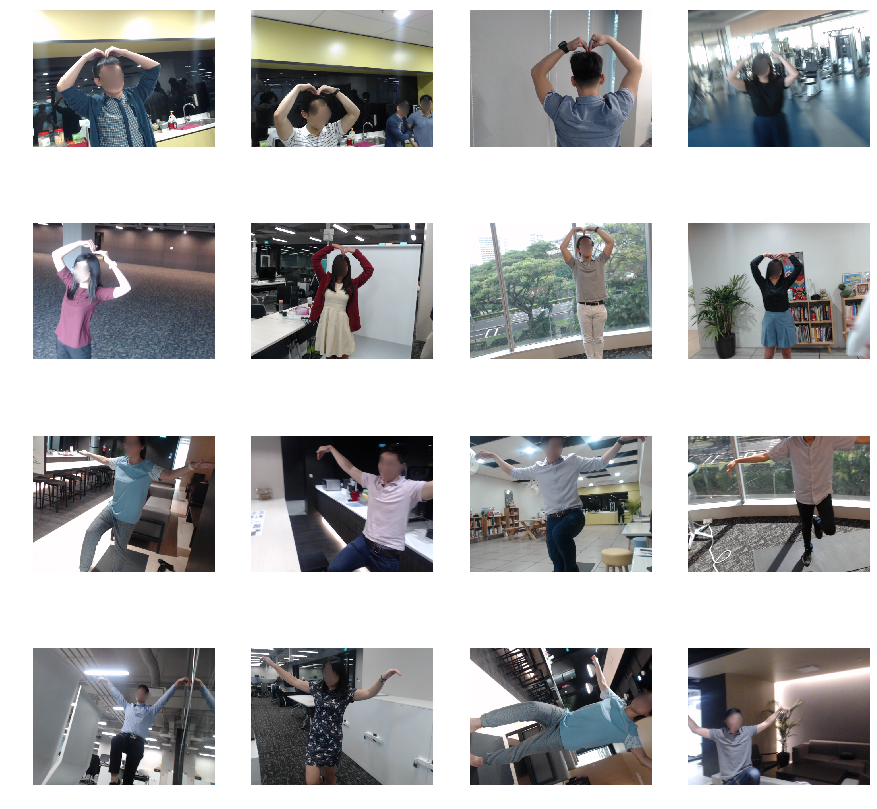

In [5]:
## Path to KoreanHeart and KungfuCrane
train_koreanheart_dir= "data/trainset_11classes_0_00000/train/KoreanHeart"
train_kungfucrane_dir= "data/trainset_11classes_0_00000/train/KungfuCrane"
train_koreanheart_fnames = os.listdir(train_koreanheart_dir)
train_kungfucrane_fnames = os.listdir(train_kungfucrane_dir)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(15, 15)

pic_index += 8
next_koreanheart_pix = [os.path.join(train_koreanheart_dir, fname) 
                for fname in train_koreanheart_fnames[pic_index-8:pic_index]]
next_kungfucrane_pix = [os.path.join(train_kungfucrane_dir, fname) 
                for fname in train_kungfucrane_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_koreanheart_pix+next_kungfucrane_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Data Preprocessing

Let's set up data generators that will read images from our source folders and convert them to float32 tensors. We'll have one generator for each training and validation folders.

### Batch
Our generators will yield batches of `32` images of size `299 x 299` and their labels.

### Feature scaling
Recall that in our MNIST/CIFAR-10 exercises, data that goes into a neural network should be normalised in a way that is easier to be processed by the network. In our case, we will preprocess our images by normalising the pixels values to be in the 0 to 1 range. This happens by dividing each pixel value by 255 and this process is known as data normalisation or rescaling.

### Generator - ImageDataGenerator
To rescale the data, we use `keras.preprocessing.image.ImageDataGenerator` class with the `rescale` parameter. This class will also allow us to instantiate generators of augmented image batches (and their labels) via `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs such as `fit_generator`, `evaluate_generator` and `predict_generator`. We used data augmentation for the training image generator. To find out more about how to do image augmentation in keras, go [here](https://keras.io/preprocessing/image/).

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Batch size
bs = 32

# All images will be resized to this value
image_size = (299, 299)

# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = train_datagen.flow_from_directory(
    directory= train_folder, # This is the source directory for training images 
    target_size=image_size, # All images will be resized to value set in image_size
    batch_size=bs,
    class_mode='categorical')

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow_from_directory(
    directory= val_folder, 
    target_size=image_size,
    batch_size=bs,
    class_mode='categorical')

Using TensorFlow backend.


Preparing generator for train dataset
Found 973 images belonging to 11 classes.
Preparing generator for validation dataset
Found 253 images belonging to 11 classes.


## Building a Small Convnet Model

The images that will go into our convnet are **299 x 299** color images. You are free to resize the images for faster training time or better accuracy.

Here, we designed a very simple architecture. It consists of three convolutional layers of stride 2 ending with a [global average pooling layer](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/). In this architecture we decided not to use a series of dense layers but instead went straight to the final softmax classification layer. Feel free to modify the model to improve the accuracy. We have introduced here a few new techniques different from the preceeding notebooks but there are many more out there that you can explore and use.

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.applications.xception import Xception

HEIGHT = 299
WIDTH = 299

base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

# Here we specify the input shape of our data 
# This should match the size of images ('image_size') along with the number of channels (3)
input_shape = (299, 299, 3)

# Define the number of classes
num_classes = 11

def build_finetune_model(base_model, dropout, fc_layers, _num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(_num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      _num_classes=num_classes)
model = finetune_model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let's summarise the model architecture:

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Next, we will configure the specifications for model training.

We train our model with `categorical_crossentropy` loss, because this is a multi-class problem. We will use the `adam` optimizer with default settings. During training, we want to monitor `accuracy` of the classification.

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

## Setting Up Checkpoints

Let's setup a [checkpoint](https://keras.io/callbacks/) to help us monitor the validation accuracy as the model trains. This checkpoint will save the model with best validation accuracy seen so far.

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'train_xception_model.hdf5'

bestValidationCheckpointer = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1)

# Terminate early if validation accuracy stop improving over 10 epochs
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

## Model Training 

Let's train on all the images in the training set, for 100 epochs, and validate against all validation images.

Note: This may take a while to run.

In [11]:
history = model.fit_generator(
        train_generator, # train generator has 973 train images
        steps_per_epoch=train_generator.samples // bs + 1,
        epochs=25,
        validation_data=val_generator, # validation generator has 253 validation images
        validation_steps=val_generator.samples // bs + 1,
        callbacks=[bestValidationCheckpointer, early]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25


ResourceExhaustedError: ignored

## Evaluating Accuracy and Loss of the Model

With a trained model, we can evaluate the model performance against the truth labels of our validation set. First, we load the best model encountered during training.

In [0]:
from keras.models import load_model

model_path = 'train_resnet50_model.hdf5'
model = load_model( model_path )

Then, we validate accuracy of the loaded model on our good old validation set.

In [0]:
val_generator.reset()

scores = model.evaluate_generator(val_generator, steps=val_generator.samples // val_generator.batch_size + 1, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

8/8 [==============================] - 8s 990ms/step
Val loss: 14.525397956606898
Val accuracy: 0.09881422919011398
